# **The Stokes equations - adaptive mesh refinement**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

A flow past a static cylinder is implemented. The effect of cylinder placement and different error functionals on adjoint fields and mesh refinement is explored. Furthermore, the relationship between total error and mesh resolution is shown.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

In [ ]:
def cstring(n): return '{0:3.1f}'.format(n)

# Define experiment flags and parameters

EXPERIMENT_CIRCLE = False
EXPERIMENT_DATA = True
EXPERIMENT_ERROR = False

RESOLUTION = 32

CIRCLE_POS = 3.5

PSI_1_1 = cstring(1);
PSI_1_2 = cstring(0);

PSI_2 = cstring(0);

PSI_3_1 = cstring(0);
PSI_3_2 = cstring(0);

all_flags = [EXPERIMENT_CIRCLE, EXPERIMENT_DATA, EXPERIMENT_ERROR]
if len([f for f in all_flags if f]) != 1: raise Exception('Select exactly one experiment')

**Define domain and mesh**

We create a rectangular mesh with a circular hole (radius 0.2).

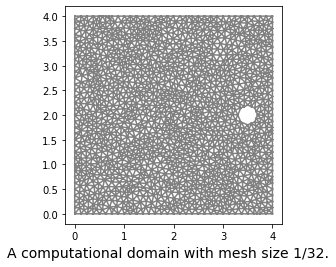

In [ ]:
# Define rectangular domain 
L = 4
H = 4

# Define circle
xc = CIRCLE_POS
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = RESOLUTION
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
txt=f"A computational domain with mesh size 1/{RESOLUTION}."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

**Define finite element approximation spaces**

The approximation space is set to piecewise quadratic polynomials for primal velocity, and piecewise linear polynomials for primal pressure.

The approximation space for the adjoint velocity and pressure can be set to quadratic and linear, respectively, or cubic and quadratic. When an error approximation is desired, the higher degree polynomials are used.

In [ ]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

# Generate mixed finite element spaces (for adjoint velocity and pressure)
if EXPERIMENT_ERROR:
  VEa = VectorElement("CG", mesh.ufl_cell(), 2)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 1)
else:
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

The inflow velocity is set to $4y(y-H)/H^2$ in x and 0 in y. At the outflow boundary the pressure will be set to 0. At the walls and cylinder boundary we will have a no-slip condition.

In [ ]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**

The primal and adjoint variational problem is solved with external body forces set to 0. The functional that describes the adjoint problem is varied to explore different scenarios.

In [ ]:
# Set boundary penalty parameter gamma 
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Set data that describe functional that defines the adjoint problem
#psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
#psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
psi1 = Expression((PSI_1_1,PSI_1_2), element = V.ufl_element())
psi2 = Expression(PSI_2, element = Q.ufl_element())
phi3 = Expression((PSI_3_1,PSI_3_2), element = V.ufl_element())

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system 
solve(res == 0, w) 

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system 
solve(res_a == 0, wa) 

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


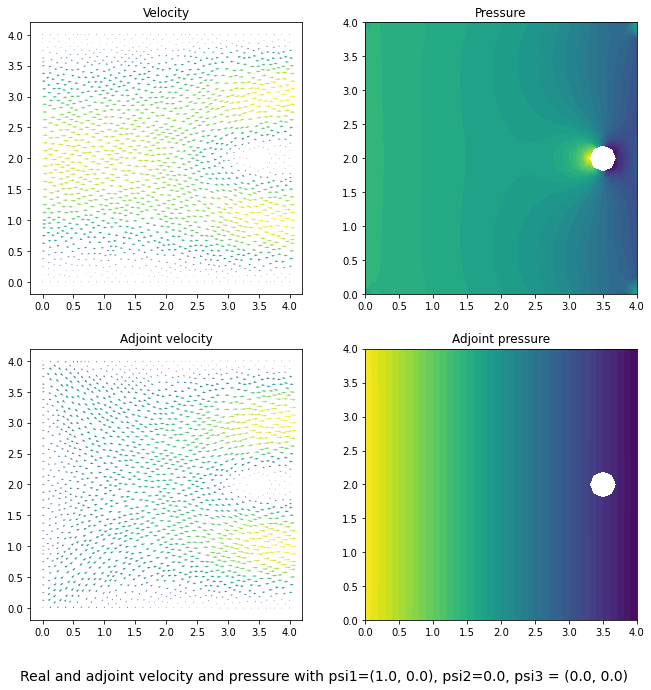

In [ ]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure(figsize=(11,11))

plt.subplot(2, 2, 1);
plot(u_fcn, title="Velocity")

plt.subplot(2, 2, 2);
plot(p_fcn, title="Pressure")

plt.subplot(2, 2, 3);
plot(phi_fcn, title="Adjoint velocity")

plt.subplot(2, 2, 4);
plot(theta_fcn, title="Adjoint pressure")

if EXPERIMENT_CIRCLE:
  txt="Real and adjoint velocity and pressure with circle at X = " + repr(CIRCLE_POS);
  plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)
if EXPERIMENT_DATA:
  txt=f"Real and adjoint velocity and pressure with psi1=({PSI_1_1}, {PSI_1_2}), psi2={PSI_2}, psi3 = ({PSI_3_1}, {PSI_3_2})";
  plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

Local error indicators for each cell and total error is calculated using the solution to the adjoint equation as a test function. Cells with an error above the global mean will be refined once.

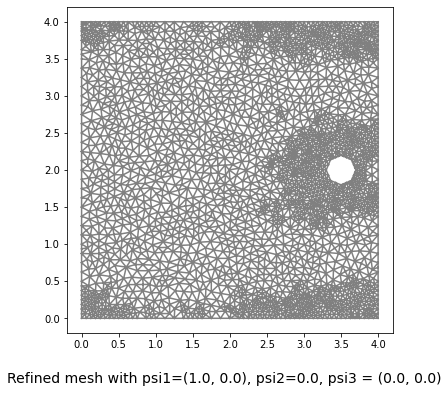

Total error = 5.613601939902303e-05


In [ ]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh 
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()] 
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure(figsize=(6, 6))
plot(mesh)
if EXPERIMENT_CIRCLE:
  txt="Refined mesh with circle at X = " + repr(CIRCLE_POS);
  plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
if EXPERIMENT_DATA:
  txt=f"Refined mesh with psi1=({PSI_1_1}, {PSI_1_2}), psi2={PSI_2}, psi3 = ({PSI_3_1}, {PSI_3_2})";
  plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err) 
print(s)

----
# Figure 1

Primal and adjoint velocity and pressure for different cylinder positions.

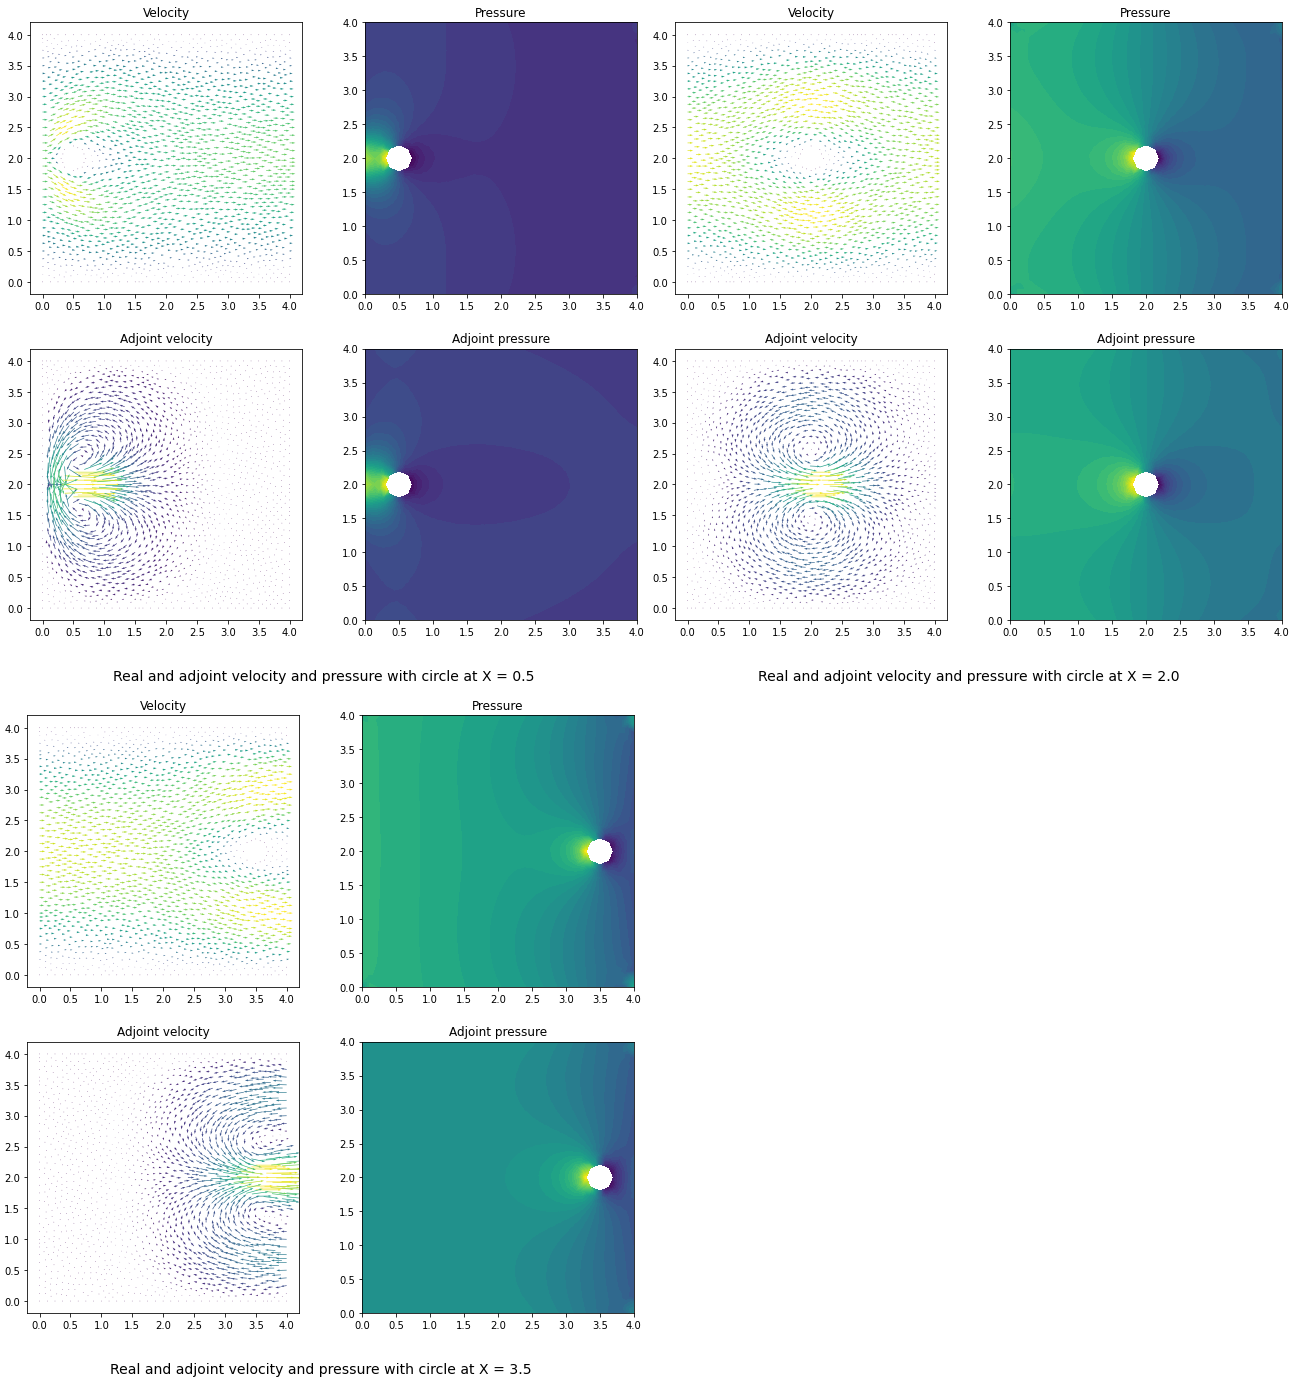

---

# Figure 2

Final mesh refinement for different cylinder positions

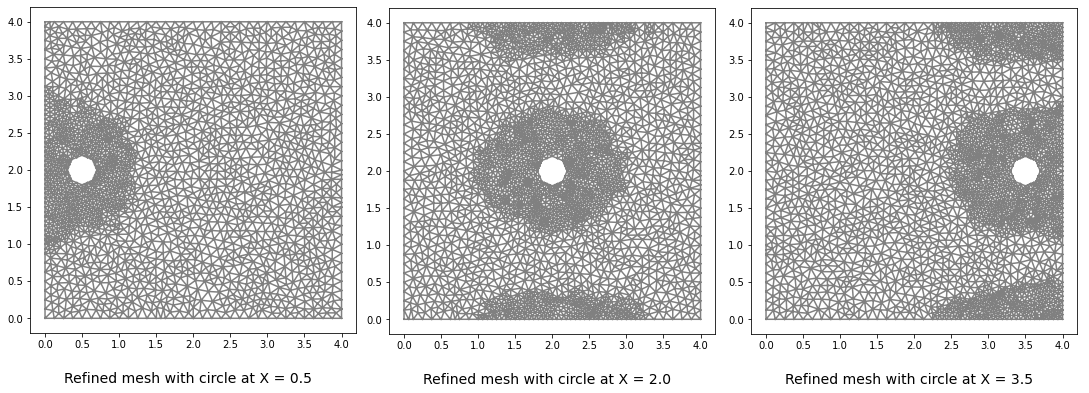

---

# Figure 3

Primal and adjoint velocity and pressure for different functionals.

Top right: Lift force

Top left: Pressure

Bottom left: Velocity in y

Bottom right: Velocity in x

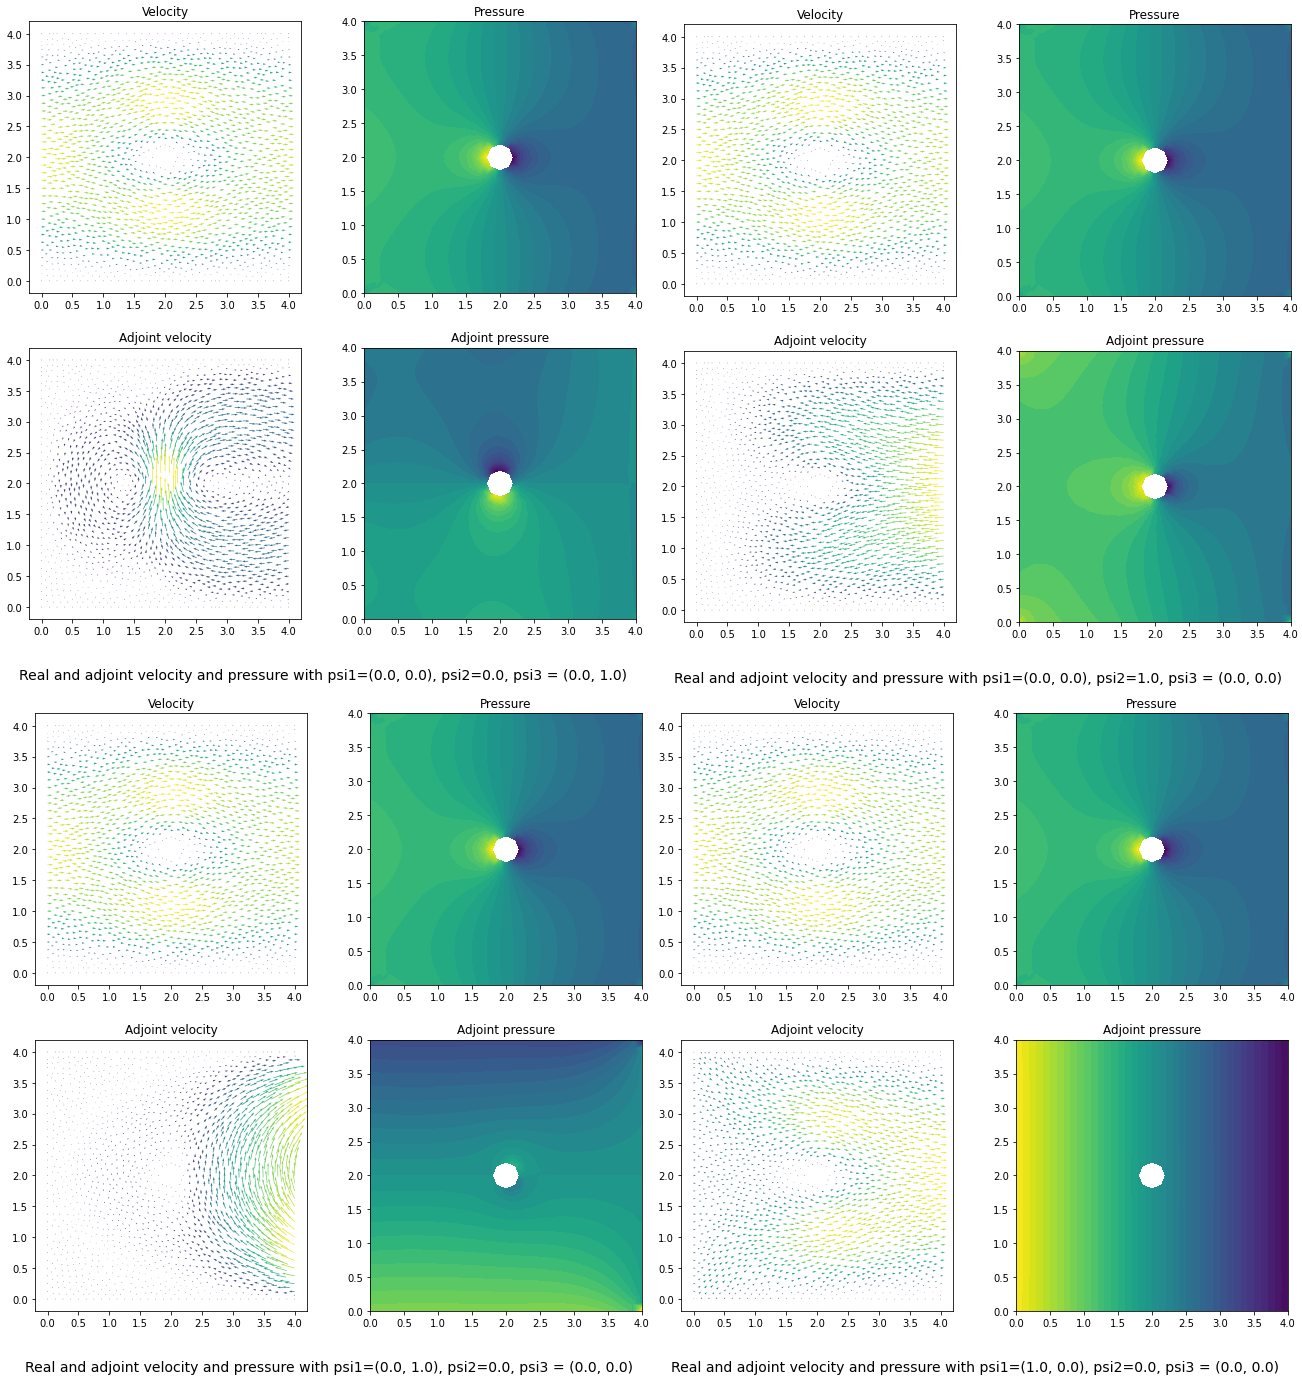

---

# Figure 4

Final mesh refinement for the above functionals.

Top right: Lift force

Top left: Pressure

Bottom left: Velocity in y

Bottom right: Velocity in x

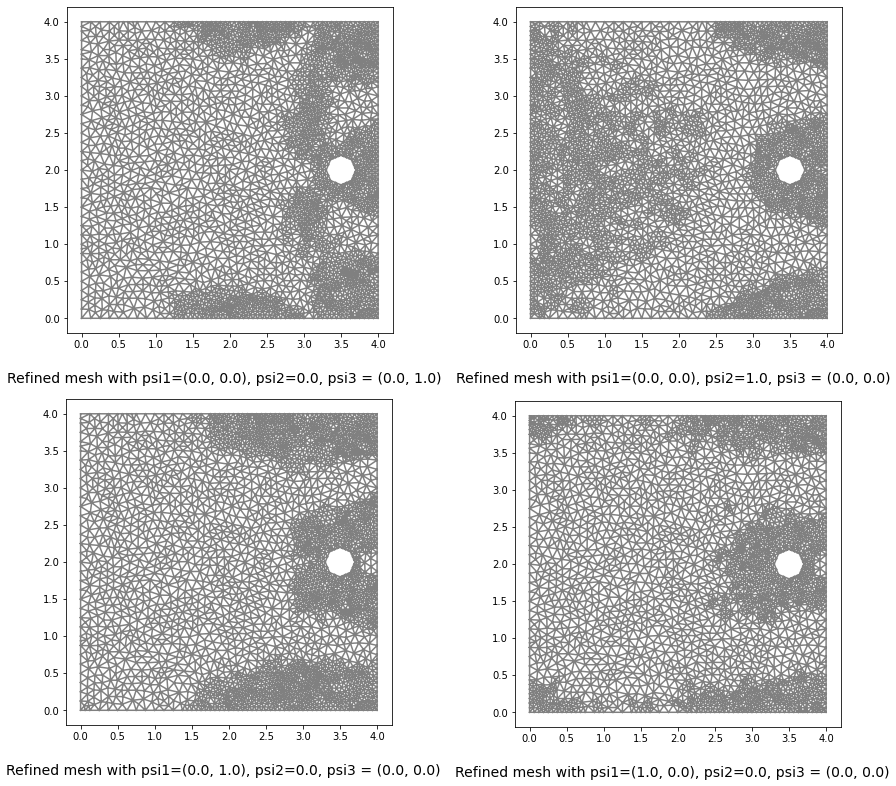

---

# Figure 5

The total absolute error as a function of mesh resolution, when the approximation space for the adjoint is one degree higher than the primal approximation space.

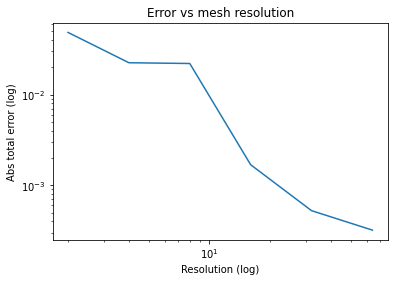

In [ ]:
res = [2, 4, 8, 16, 32, 64]
error_higher_order = [0.04833920117419044, -0.022406814185281836, 0.021973722420779548, -0.0016831261953365922, 0.0005244420609670169, -0.00032004693121137916]
plt.loglog(res, np.abs(error_higher_order));
plt.title('Error vs mesh resolution'); plt.xlabel('Resolution (log)'); plt.ylabel('Abs total error (log)')
plt.show()

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh. This error indicator was used go guide mesh refinement.

The primal and adjoint velocites and pressure (with respect to the drag force) for three different cylinder positions can be seen in Figure 1. The resulting mesh refinements can be seen in Figure 2.

We see that the adjoint velocity is focused in a vortex around the cylinder for all positions. Predictably, we also get a mesh refinement around the cylinder for all three positions, but with some extra refinement towards the inflow boundary when the cylinder is close to the inflow. When the cylinder is further back in the channel, we also get some refinement at the upper and lower walls. Since the adjoint is low close to these walls, it indicates that the refinement is due to a large residual at these positions, since the error is a product of the adjoint field and the residual.

In Figure 3, we see primal and adjoint velocites and pressure for different functionals. The corresponding mesh refinements can be seen in Figure 4. We see that the adjoint pressure and adjoint velocity changes drastically for different functionals. For example, the adjoint velocity is focused around the cylinder with respect to the lift force, but behind the cylinder with respect to horizontal velocity. However, the mesh refinement is quite similar for all cases, with the only notable outlier being the extra refinement around the inflow for the pressure functional (presumebly due to the higher pressure at the inflow).

I find it hard to reason about the apperance of the adjoint pressure field, however. For example, why is it almost linear in y for vertical velocity? I would expect it to be symmetrical in y instead, since the problem is symmetrical in the y dimension.

With the adjoint spaces the same order as the primal approximation spaces, we always get a total error of 0. However, if the adjoint approximation space is 1 order higher than the primal approximation space, we get a non-zero error that decreases with increasing resolution. In Figure 5, we see how the total error decreases when the mesh resolution increases.